In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams

from utils import *
from methods import *
from models import *
from plotting_functions import *

In [3]:
# load trained model
model = torch.load('./optimal-models/JV1000')
phases = model.phases.clone().detach().numpy()
wrapped_phases = model.unit_cell.wrap(phases)

[(<Figure size 432x288 with 3 Axes>, <AxesSubplot:>),
 (<Figure size 432x288 with 3 Axes>, <AxesSubplot:>),
 (<Figure size 432x288 with 3 Axes>, <AxesSubplot:>)]

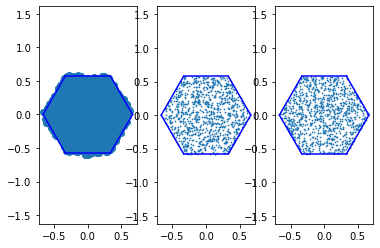

In [4]:
fig, axs = plt.subplots(ncols=3)
axs[0].scatter(*phases.T)
axs[1].scatter(*wrapped_phases.T,s=0.5)
axs[2].scatter(*model.unit_cell.sample(phases.shape[0]).T,s=0.5)
[axs[i].axis('equal') for i in range(len(axs))]
[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]

### Test (Linear) decoding performance

In [5]:
def test_decoding(model,nsamples_space=1000):
    r = model.unit_cell.sample(nsamples_space)
    activity = model.forward(torch.tensor(r,dtype=torch.float32))
    model.train_decoder(torch.tensor(r,dtype=torch.float32))
    r_pred = model.decode(activity)
    r_pred = r_pred.detach().numpy()
    #r_wrapped = model.unit_cell.wrap(r_pred)
    return r, model.unit_cell.geodesic(r,r_pred)#np.sum((r-r_wrapped)**2,axis=-1)

0.40315174630384765


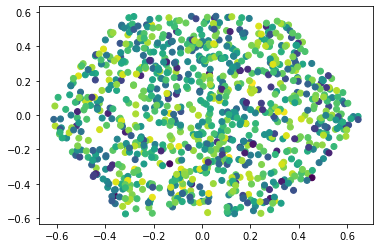

In [6]:
r, decoding_error = test_decoding(model)
print(np.mean(decoding_error))
plt.scatter(*r.T,c=decoding_error)

### Show The Jacobian

In [7]:
def test_detJ(model,nsamples_space=10000):
    r = model.unit_cell.sample(nsamples_space)
    J = model.jacobian(torch.tensor(r,dtype=torch.float32))
    det_J = model.the_jacobian(J)
    return r,det_J.detach().numpy()

In [8]:
r,detJ = test_detJ(model)

Text(0.5, 1.0, 'Var(det(J^T J)) = 2.0465254380042097e-08')

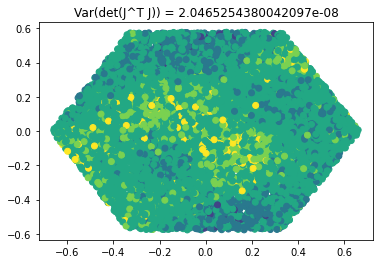

In [9]:
plt.scatter(*r.T,c=detJ)
plt.title(f"Var(det(J^T J)) = {np.var(detJ)}")

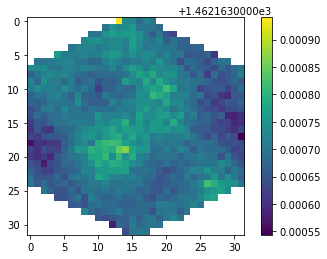

In [10]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,detJ,bins=32).statistic
plt.imshow(hist2d)
plt.colorbar()

### Show (low-dimensional projection) manifold

In [11]:
def show_manifold(model,nsamples_space=10000):
    #r = np.random.uniform(-1.2/2,1.2/2,size=(64**2,2))
    #r = model.unit_cell.sample(nsamples_space)
    #r = create_board(1.2,to_torch_tensor=False).reshape(-1,2)
    #r = r[model.unit_cell.is_in_hexagon(r)]
    r = model.unit_cell.mesh(64)
    activity = model.forward(torch.tensor(r,dtype=torch.float32)).detach().numpy()
    projection = umap.UMAP(n_neighbors=15,n_components=3)
    return projection.fit_transform(activity), projection, activity

In [12]:
manifold, projection, activity = show_manifold(model)

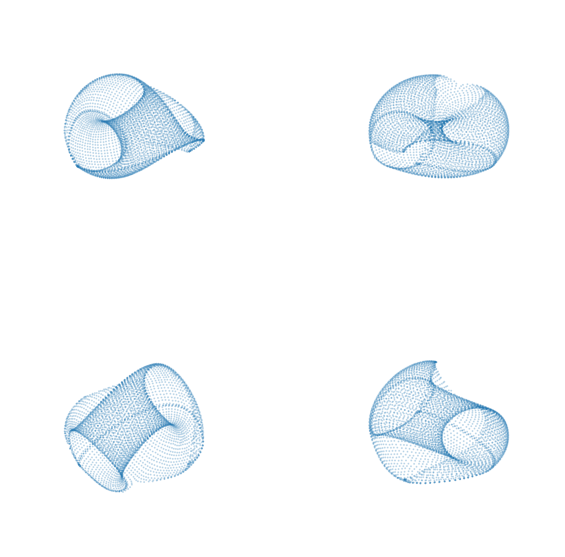

In [13]:
scatter3d(manifold,ncols=2,nrows=2,azim_elev_title=False,figsize=(10,10),alpha=0.2);

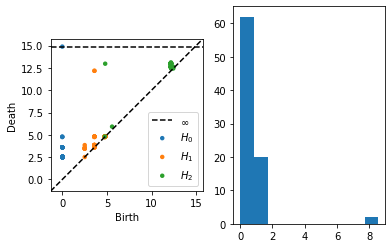

In [14]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0]);

### Test whether distribution is uniform

In [15]:
def permutation_test(X,Y,statistic,nperms=1000,alternative='two-sided'):
    XY_statistic = statistic(X,Y)
    H0 = np.zeros(nperms)
    N = X.shape[0]
    XY = np.concatenate([X,Y])
    for i in tqdm.trange(nperms):
        XY = np.random.permutation(XY)
        H0[i] = statistic(XY[:N],XY[N:])
    leq = np.sum(XY_statistic <= H0)
    # +1 corretion assumes XY_statistic also included in H0
    leq = (leq+1) / (nperms+1)
    geq = np.sum(XY_statistic >= H0)
    geq = (geq+1) / (nperms+1)
    if alternative == 'greater':
        pvalue = geq
    elif alternative == 'less':
        pvalue = leq
    else:
        pvalue = min(geq,leq)*2
    return XY_statistic, pvalue, H0

In [28]:
def energy_statistic(X,Y):
    #all_to_all_fn = lambda X,Y: np.sum(np.linalg.norm(X[:,None]-Y[None],axis=-1))
    all_to_all_fn = lambda X,Y: np.mean(np.linalg.norm(X[:,None]-Y[None],axis=-1))
    #return 2*all_to_all_fn(X,Y)/(M*N) - all_to_all_fn(X,X)/(M*(M-1)) - all_to_all_fn(Y,Y)/(N*(N-1))
    return 2*all_to_all_fn(X,Y) - all_to_all_fn(X,X) - all_to_all_fn(Y,Y)

def energy_statistic_dist(X,Y,dist):
    #all_to_all_fn = lambda X,Y: np.sum(np.linalg.norm(X[:,None]-Y[None],axis=-1))
    all_to_all_fn = lambda X,Y: np.mean(dist(X[:,None],Y[None],axis=-1))
    #return 2*all_to_all_fn(X,Y)/(M*N) - all_to_all_fn(X,X)/(M*(M-1)) - all_to_all_fn(Y,Y)/(N*(N-1))
    return 2*all_to_all_fn(X,Y) - all_to_all_fn(X,X) - all_to_all_fn(Y,Y)

In [29]:
X = phases
Y = model.unit_cell.sample(phases.shape[0]).astype(dtype=np.float32)
#X = np.random.uniform(-0.1,0.1,size=Y.shape)
X.shape,Y.shape

((1000, 2), (1000, 2))

In [30]:
stat, p, H0 = permutation_test(X[:10],Y[:10],energy_statistic,nperms=1000,alternative='greater')
stat,p

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 14296.78it/s]


(0.05619931221008301, 0.17582417582417584)

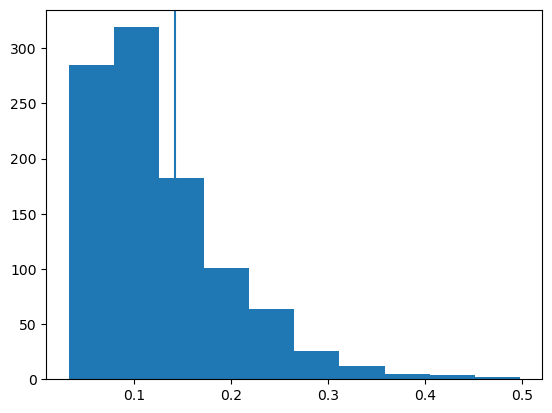

In [21]:
plt.hist(H0)
plt.axvline(stat)

In [22]:
def energy_statistic2(X,Y,axis=-1):
    """
    Energy statistic for use with scipy.stats.permutation_test.
    They assume a silly data format. See below
    
    Parameters:
        
    """
    if X.ndim == 2:
        X,Y=X.T[None],Y.T[None]
    elif X.ndim == 3:
        X,Y = np.transpose(X,axes=(0,2,1)),np.transpose(Y,axes=(0,2,1))
    X_to_X = np.mean(np.linalg.norm(X[:,:,None]-X[:,None],axis=-1),axis=(-1,-2))
    X_to_Y = np.mean(np.linalg.norm(X[:,:,None]-Y[:,None],axis=-1),axis=(-1,-2))
    Y_to_Y = np.mean(np.linalg.norm(Y[:,:,None]-Y[:,None],axis=-1),axis=(-1,-2))
    res = 2*X_to_Y - X_to_X - Y_to_Y
    return res

In [26]:
res = scipy.stats.permutation_test((X[:10],Y[:10]),statistic=energy_statistic2,
                                   n_resamples=1000,vectorized=True,axis=0,alternative='greater')
res.statistic, res.null_distribution.shape, res.pvalue

(array([0.14143133], dtype=float32), (1000,), 0.2887112887112887)

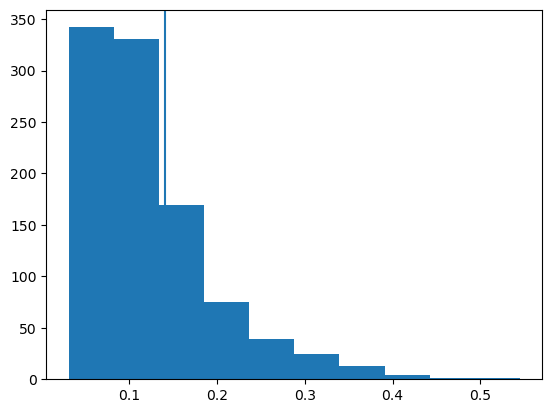

In [27]:
plt.hist(res.null_distribution)
plt.axvline(res.statistic)